# Landslide Detection Challenge - Starter Notebook

Welcome to the Landslide Detection Challenge! This notebook will guide you through:
1. Loading and exploring the multi-band dataset provided in `.npy` format.
2. Visualizing the multi-band satellite data and understanding label distribution.
3. Building and evaluating a baseline model to classify landslide and non-landslide images.

Let’s get started with loading and understanding the data!


## Block 1: Import Libraries

In [ ]:
# Import necessary libraries
import os
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import lightgbm as lgb
from lightgbm import LGBMClassifier
from optuna.samplers import RandomSampler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import optuna

### Explanation
We import the required libraries:
- **os**: for file and directory handling.
- **numpy**: for numerical operations, particularly for loading `.npy` files.
- **pandas**: for data handling with CSV files.
- **matplotlib.pyplot**: for visualizing data, such as label distributions.
- **sklearn.model_selection.train_test_split**: for splitting data into training and validation sets.
- **tensorflow.keras**: for building and training a neural network model.


## Block 2: Define Paths and Load CSV Files

In [ ]:
# Define paths for the dataset (remember to unzip the dataset first!)
train_csv_path = '/kaggle/input/landslide-detection/Train.csv'  # Path to the training labels CSV file
test_csv_path = '/kaggle/input/landslide-detection/Test.csv'    # Path to the test image IDs CSV file
train_data_path = '/kaggle/input/landslide-detection/train_data/train_data'  # Folder where .npy train files are located
test_data_path = '/kaggle/input/landslide-detection/test_data/test_data'    # Folder where .npy test files are located

# Load Train.csv and inspect the data
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
print("Train.csv:")
print(train_df.head())

In [ ]:
train_df.label.value_counts()

### Explanation
- **Define Paths**: Specify paths to `Train.csv`, `Test.csv`, and folders containing `.npy` files for training and testing images.
- **Load Train.csv**: We read the `Train.csv` file, which contains `ID` and `label` columns. The `label` is binary, indicating whether the image contains a landslide (1) or not (0).


## Block 4: Load, Normalize, and Display Sample Multi-band Images

In [ ]:
# Function to load and normalize .npy images
def load_and_normalize_npy_image(image_id, folder_path):
    """Loads a .npy file, normalizes each band, and returns the normalized image."""
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path, mmap_mode='r')

    img = img.astype('float32')  # ensure float for normalization

    # Normalize per band (channels last)
    min_vals = img.min(axis=(0, 1), keepdims=True)
    max_vals = img.max(axis=(0, 1), keepdims=True)
    img_normalized = (img - min_vals) / (max_vals - min_vals + 1e-8)

    return img_normalized

# Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Vertical-Vertical)", "Descending VH (Vertical-Horizontal)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Vertical-Vertical)", "Ascending VH (Vertical-Horizontal)",
    "Ascending Diff VV", "Ascending Diff VH"
]

X = np.array([load_and_normalize_npy_image(image_id, train_data_path) for image_id in train_df['ID']])
y = train_df['label'].values
X_test = np.array([load_and_normalize_npy_image(image_id, test_data_path) for image_id in test_df['ID']])

### Explanation
This block provides a complete view of the 12 individual bands with the corrected descriptions for ascending and descending radar bands.

1. **Band Descriptions**:
   - **Bands 1-4**: Visible and Near Infrared bands (Red, Green, Blue, NIR).
   - **Bands 5-8**: Descending radar bands:
     - **Band 5**: Descending VV (Vertical-Vertical polarization).
     - **Band 6**: Descending VH (Vertical-Horizontal polarization).
     - **Band 7**: Descending Diff VV.
     - **Band 8**: Descending Diff VH.
   - **Bands 9-12**: Ascending radar bands:
     - **Band 9**: Ascending VV (Vertical-Vertical polarization).
     - **Band 10**: Ascending VH (Vertical-Horizontal polarization).
     - **Band 11**: Ascending Diff VV.
     - **Band 12**: Ascending Diff VH.

2. **Plotting Layout**:
   - A 3x4 grid layout displays each band as a grayscale image.
   - Each subplot includes the band number and description for easy reference.
   - `plt.subplots_adjust` adds spacing between the plots to improve readability.


## Feature Extraction

In [ ]:
# Path to the folder containing .npy images

def extract_features(img):
    # img: (batch, H, W, 12)

    # Bands 1-4: Optical
    red, green, blue, nir = [img[:, :, :, i] for i in range(4)]
    ndvi = (nir - red) / (nir + red + 1e-5)
    ndwi = (green - nir) / (green + nir + 1e-5)

    # Radar Descending
    vv_desc, vh_desc = img[:, :, :, 4], img[:, :, :, 5]
    vv_vh_ratio_desc = (vv_desc + 1e-5) / (vh_desc + 1e-5)

    # Radar Ascending
    vv_asc, vh_asc = img[:, :, :, 8], img[:, :, :, 9]
    vv_vh_ratio_asc = (vv_asc + 1e-5) / (vh_asc + 1e-5)

    # Expand NDVI etc. to (batch, H, W, 1) before concatenation
    ndvi = ndvi[..., np.newaxis]
    ndwi = ndwi[..., np.newaxis]
    vv_vh_ratio_desc = vv_vh_ratio_desc[..., np.newaxis]
    vv_vh_ratio_asc = vv_vh_ratio_asc[..., np.newaxis]

    # Concatenate along channel axis
    features = np.concatenate([img, ndvi, ndwi, vv_vh_ratio_desc, vv_vh_ratio_asc], axis=-1)
    return features


X_features = extract_features(X)
X_features_test = extract_features(X_test)

## Block 5: Prepare Data for Model Training

In [ ]:
# Normalize
X_train, X_val, y_train, y_val = train_test_split(
    X_features, y_labels, 
    test_size=0.2, 
    stratify=y_labels, 
    random_state=SEED
)
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE)

# Add custom augmentations
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform([], 0, 4, dtype=tf.int32))
    return image, label

train_ds = train_ds.map(augment)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)

### Explanation

1. **Load Data**:
   - We define `load_npy_image` to load `.npy` files as raw images.
   - `X` is created by loading each image using `load_npy_image` based on the image IDs in `train_df`.
   - `y` contains the labels from `train_df`.

2. **Stratified Data Split**:
   - We split the data into `X_train`, `X_val`, `y_train`, and `y_val` while preserving class distribution using `stratify=y`.

3. **ImageDataGenerator for Training**:
   - `train_datagen` is configured with data augmentation options to increase the diversity of the training data.

4. **ImageDataGenerator for Validation**:
   - `val_datagen` loads the validation data without augmentation.

5. **Generators**:
   - `train_ds` and `val_ds` are created using `.flow()`, which yields data in batches for efficient training and validation.

## Block 6: Define and Compile a CNN Model with Focal Loss

In [ ]:
# Precision
def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(K.clip(y_pred, 0, 1))   # ✅ Threshold predictions
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Recall
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(K.clip(y_pred, 0, 1))   # ✅ Threshold predictions
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# F1 Score
def f1_m(y_true, y_pred):
    p = precision_m(y_true, y_pred)
    r = recall_m(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

# Define the Focal Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for binary classification.

    Parameters:
        gamma (float): Focusing parameter; typically set to 2.0.
        alpha (float): Balancing factor; typically set to 0.25.

    Returns:
        Binary Focal Loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)

        # Calculate focal loss
        fl = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)
        return K.mean(fl)

    return focal_loss_fixed

model = Sequential([
    # First convolutional block
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth convolutional block for deeper feature extraction
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Flatten and add dense layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])


# Compile the model with Focal Loss and additional metrics
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.5),
    metrics=['accuracy']  # Additional metrics
)

# Display the model summary
model.summary()

### Explanation

This code defines a Convolutional Neural Network (CNN) with custom metrics (Precision, Recall, and F1 Score) and **Focal Loss** for training, making it suitable for imbalanced datasets.

#### Key Components

1. **Custom Metrics**:
   - `precision_m`: Calculates the proportion of true positive predictions out of all positive predictions, which helps evaluate the model’s accuracy in predicting positive (landslide) samples.
   - `recall_m`: Measures the proportion of true positives out of all actual positives, reflecting the model’s ability to detect all positive cases.
   - `f1_m`: Combines Precision and Recall into a single score using the harmonic mean, making it useful for evaluating the model on imbalanced datasets.

2. **Focal Loss Function**:
   - Focal Loss is designed to focus on hard-to-classify examples, making it particularly beneficial for imbalanced datasets.
   - Parameters:
     - `gamma=2.0`: Adjusts the focusing mechanism. Higher values place more focus on misclassified examples.
     - `alpha=0.25`: Balances the contribution of positive and negative samples, ensuring the loss calculation doesn’t get dominated by the majority class.
   - The function `focal_loss_fixed` calculates Focal Loss by:
     - Clipping predictions to avoid `log(0)`.
     - Calculating the probability for each prediction (`p_t`), where correct predictions contribute less to the loss.
     - Applying the focal scaling factor `(1 - p_t)^{\gamma}` to emphasize harder examples in the loss computation.

3. **CNN Model Architecture**:
   - The CNN is designed with four convolutional blocks, each containing:
     - **Conv2D layers**: Extract features with increasing complexity as the model goes deeper.
     - **BatchNormalization layers**: Normalize activations, speeding up convergence and improving stability.
     - **MaxPooling2D layers**: Down-sample feature maps, reducing spatial dimensions and capturing abstract patterns.
     - **Dropout layers**: Applied with increasing rates, reducing overfitting by randomly deactivating nodes during training.
   - Following the convolutional blocks:
     - **Flatten**: Converts 2D feature maps to a 1D vector.
     - **Dense layers**: Two fully connected layers with ReLU activation capture higher-level features, with Dropout for regularization.
     - **Sigmoid Output Layer**: Used for binary classification, outputs the probability of each class (No Landslide or Landslide).

4. **Model Compilation**:
   - `optimizer='adam'`: An adaptive optimizer that adjusts the learning rate automatically during training.
   - `loss=focal_loss(gamma=2.0, alpha=0.25)`: Focal Loss to handle class imbalance.
   - `metrics=['accuracy', precision_m, recall_m, f1_m]`: Additional metrics for a comprehensive evaluation of the model's performance on imbalanced data.

5. **Model Summary**:
   - `model.summary()` displays the model’s architecture, showing layer types, output shapes, and parameter counts. This summary helps verify that the model structure matches expectations before training begins.

## Block 7: Train the Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

# Create a checkpoint callback that saves the best model based on validation loss
callback = [ModelCheckpoint(
                "kaggle/working/best_model.h5",            
                monitor='val_loss',   
                verbose=1,                  
                save_best_only=True,       
                mode='min'),
            
            EarlyStopping(
                monitor='val_loss', patience=5)
           ]

#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weights_dict = dict(enumerate(class_weights))
# Train the model using the generators with the checkpoint callback
history = model.fit(
    train_ds,       # Train generator
    epochs=50,
    validation_data=val_ds,  # Validation generator
    callbacks=[callback],  # Include the checkpoint callback in training
)


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20
N_SPLITS = 5

# ✅ Encode labels
class_names = sorted(train_df['label'].unique())
label_to_index = {name: i for i, name in enumerate(class_names)}
train_df['label_idx'] = train_df['label'].map(label_to_index)

paths = train_df['image_path'].values
labels = train_df['label_idx'].values

# ✅ Load function
def load_image(path, label, training=True):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)

    return img, label


def build_dataset(x_paths, y_labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((x_paths, y_labels))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1024, seed=42)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# ✅ Model
def build_efficientnetb3():
    base_model = tf.keras.applications.EfficientNetB3(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False 
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ✅ StratifiedKFold loop
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(paths, labels)):
    print(f"\n🔹 Fold {fold+1}/{N_SPLITS}")
    
    train_paths, val_paths = paths[train_idx], paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    train_ds = build_dataset(train_paths, train_labels, training=True)
    val_ds = build_dataset(val_paths, val_labels, training=False)

    # ✅ Compute class weights for this fold
    cw_values = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(cw_values))
    print("Class Weights:", class_weights)

    # ✅ Build and train model
    model = build_efficientnetb3()
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
    ]

    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    # Get predictions
    y_true = []
    y_pred = []
    
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    
    # Compute F1
    f1 = f1_score(y_true, y_pred) 
    print("Validation F1 Score:", f1)
    del model
    gc.collect()
    tf.keras.backend.clear_session()

### Explanation

1. **Model Training**:
   - `model.fit` is updated to use the `train_generator` and `val_generator`.
   - `steps_per_epoch` and `validation_steps` control how many batches are processed per epoch for training and validation.
2. **Efficiency**:
   - Using a generator allows the model to load data in batches, reducing memory usage and making training feasible for large datasets.

## Block 8: Plot Training and Validation Accuracy

In [ ]:
def evaluate_model(model, X_test):

    # Predict probabilities
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    # Compute F1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Detailed report
    print(classification_report(y_test, y_pred))


In [ ]:
predictions = model.predict(val_gen)
y_pred = (predictions > 0.5).astype(int)
y_test = val_df['label']
cm = confusion_matrix(val_df['label'], y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred, average='binary'))

In [ ]:
def threshold_tuning(model):
    scores = []
    thresholds = np.linspace(0.1, 1, 10)
    for thresh in thresholds:
        y_pred = model.predict(X_test)
        y_tuned = (y_pred > thresh).astype(int)
        scores.append(f1_score(y_test, y_tuned))

    fig = px.line(x=thresholds, y=scores, title='Threshold Tuning', template='plotly_white')
    fig.update_traces(line=dict(color='red'))
    fig.update_layout(xaxis_title='Thresholds',
                      yaxis_title='F1 Scores',
                      height=500,
                      width=800)
    
    fig.show()

threshold_tuning(model)

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


### Explanation
This plot shows the **training and validation accuracy** as well as the **training and validation loss** over the epochs, allowing us to visually inspect the model’s learning behavior:

- **Steady Improvements in Both Accuracy and Loss**: Consistent increases in accuracy and decreases in loss for both training and validation sets indicate effective learning and good generalization.

- **Divergence Between Training and Validation Metrics**:
  - If **training accuracy is high** but **validation accuracy is much lower** (with validation loss increasing), this suggests **overfitting**. The model may perform well on training data but fails to generalize to new data.
  - If both **training and validation accuracy remain low** and losses are high, this indicates **underfitting**, meaning the model may not be complex enough to capture patterns in the data.

This combined plot of accuracy and loss offers a comprehensive view of model performance, helping us assess both how well the model fits the training data and how well it generalizes to new, unseen data.


# Ensemble Methods

In [ ]:
def load_image(image_id, folder_path):
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path, mmap_mode='r')
    img = img.astype('float32')
    return img

X = np.array([load_image(image_id, train_data_path) for image_id in train_df['ID']])
X_test_arrays = np.array([load_image(image_id, test_data_path) for image_id in test_df['ID']])
y = train_df['label'].values

In [ ]:
def extract_features(img):
    # img: (batch, H, W, 12)

    # Bands 1-4: Optical
    red, green, blue, nir = [img[:, :, :, i] for i in range(4)]
    ndvi = (nir - red) / (nir + red + 1e-5)
    ndwi = (green - nir) / (green + nir + 1e-5)

    # Radar Descending
    vv_desc, vh_desc = img[:, :, :, 4], img[:, :, :, 5]
    vv_vh_ratio_desc = (vv_desc + 1e-5) / (vh_desc + 1e-5)

    # Radar Ascending
    vv_asc, vh_asc = img[:, :, :, 8], img[:, :, :, 9]
    vv_vh_ratio_asc = (vv_asc + 1e-5) / (vh_asc + 1e-5)

    # Expand NDVI etc. to (batch, H, W, 1) before concatenation
    ndvi = ndvi[..., np.newaxis]
    ndwi = ndwi[..., np.newaxis]
    vv_vh_ratio_desc = vv_vh_ratio_desc[..., np.newaxis]
    vv_vh_ratio_asc = vv_vh_ratio_asc[..., np.newaxis]

    # Concatenate along channel axis
    features = np.concatenate([img, ndvi, ndwi], axis=-1)
    return features

X_features = extract_features(X)
X_test_features = extract_features(X_test_arrays)

In [ ]:
def means(df, X):
    # Bands 4 to 12 → index 3 to 11
    df1 = df.copy()
    for i, band in enumerate(range(12)):
        df1[f'band{band+1}_mean'] = X[:, :, :, band].mean(axis=(1, 2))
        df1[f'band{band+1}_std']  = X[:, :, :, band].std(axis=(1, 2))
        df1[f'band{band+1}_min']  = X[:, :, :, band].min(axis=(1, 2))
        df1[f'band{band+1}_max']  = X[:, :, :, band].max(axis=(1, 2))

    # Derived features (NDVI, NDWI, radar)
    for name, idx in zip(['ndvi', 'ndwi'], [12, 13]):
        df[f'{name}_mean'] = X[:, :, :, idx].mean(axis=(1, 2))
        df[f'{name}_std']  = X[:, :, :, idx].std(axis=(1, 2))
        df[f'{name}_min']  = X[:, :, :, idx].min(axis=(1, 2))
        df[f'{name}_max']  = X[:, :, :, idx].max(axis=(1, 2))

    return df1


# Apply to training dataframe
training_df = means(train_df, X_features)
testing_df = means(test_df, X_test_features)

In [208]:
X_train.shape

(5360, 64)

In [210]:
from sklearn.feature_selection import SelectFromModel
lgb_model = XGBClassifier(random_state=42)

X_df = training_df.drop(columns=['ID', 'label'])
y_df = training_df['label']

#selector = SelectFromModel(lgb_model, threshold='median', prefit=False)
#selector.fit(X_df, y_df)
# Get selected features
#selected_features = X_df.columns[selector.get_support()]
#X_selected = X_df[selected_features]

In [211]:
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, stratify=y_df, random_state=42)
xgb =XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [212]:
def cross_validate_model(model, X, y, n_splits=5, random_state=42):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    oof_preds = np.zeros_like(y, dtype=float)
    f1_scores, acc_scores = [], []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold+1}/{n_splits}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        
        # Fit model
        model.fit(X_train, y_train)
        
        # Predict probabilities or classes
        y_pred = model.predict(X_val)
        
        # Save OOF predictions
        oof_preds[val_idx] = y_pred
        
        # Compute metrics
        f1 = f1_score(y_val, y_pred, average='binary')
        acc = accuracy_score(y_val, y_pred)
        f1_scores.append(f1)
        acc_scores.append(acc)
        
        print(f"Fold {fold+1} F1: {f1:.4f} | Accuracy: {acc:.4f}")
    
    print("="*40)
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")

cross_validate_model(xgb, X_train, y_train)

Fold 1/5
Fold 1 F1: 0.8324 | Accuracy: 0.9440
Fold 2/5
Fold 2 F1: 0.8493 | Accuracy: 0.9487
Fold 3/5
Fold 3 F1: 0.8156 | Accuracy: 0.9384
Fold 4/5
Fold 4 F1: 0.8468 | Accuracy: 0.9487
Fold 5/5
Fold 5 F1: 0.8174 | Accuracy: 0.9375
Mean F1 Score: 0.8323
Mean Accuracy: 0.9435


F1 Score: 0.8247



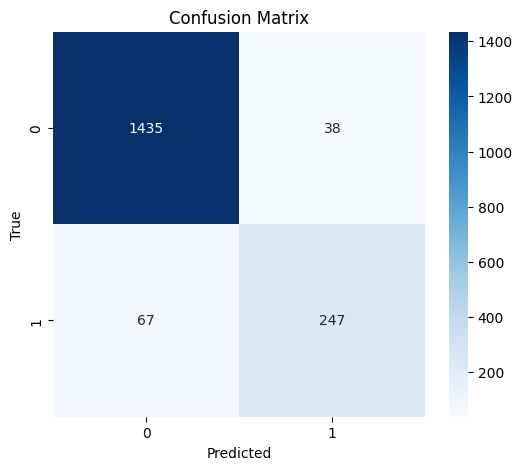

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1473
           1       0.87      0.79      0.82       314

    accuracy                           0.94      1787
   macro avg       0.91      0.88      0.89      1787
weighted avg       0.94      0.94      0.94      1787



In [164]:
def evaluate_model(model, X_test, y_test):

    # Predict probabilities
    y_pred = model.predict(X_test)

    # Compute F1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Detailed report
    print(classification_report(y_test, y_pred))


evaluate_model(xgb, X_val, y_val)

In [165]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "random_state": 42,

    }

    f1_scores = []

    model = XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
        )

    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred))

    return np.mean(f1_scores)

optuna.logging.set_verbosity(optuna.logging.CRITICAL)

xgb_study = optuna.create_study(direction="maximize", sampler=RandomSampler())
xgb_study.optimize(objective, n_trials=30)

print("Best F1:", xgb_study.best_value)
print("Best Params:", xgb_study.best_params)

Best F1: 0.8447412353923205
Best Params: {'max_depth': 7, 'learning_rate': 0.17935511647434016, 'subsample': 0.7222769947017452, 'colsample_bytree': 0.9238061037232049, 'min_child_weight': 5.949561631349664, 'gamma': 2.24834782865508, 'reg_lambda': 7.274772547972398e-07, 'reg_alpha': 0.9214834958047581}


In [177]:
best_xgb = XGBClassifier(**xgb_study.best_params)
cross_validate_model(best_xgb, X_df, y_df)

Fold 1/5
Fold 1 F1: 0.8374 | Accuracy: 0.9441
Fold 2/5
Fold 2 F1: 0.8083 | Accuracy: 0.9357
Fold 3/5
Fold 3 F1: 0.8248 | Accuracy: 0.9426
Fold 4/5
Fold 4 F1: 0.8415 | Accuracy: 0.9454
Fold 5/5
Fold 5 F1: 0.8240 | Accuracy: 0.9405
Mean F1 Score: 0.8272
Mean Accuracy: 0.9417


In [168]:
def threshold_tuning(model, X_test, y_test):
    scores = []
    thresholds = np.linspace(0.1, 1, 10)
    for thresh in thresholds:
        y_pred = model.predict_proba(X_test)[:, 1]
        y_tuned = (y_pred > thresh).astype(int)
        scores.append(f1_score(y_test, y_tuned))

    fig = px.line(x=thresholds, y=scores, title='Threshold Tuning', template='plotly_white')
    fig.update_traces(line=dict(color='red'))
    fig.update_layout(xaxis_title='Thresholds',
                      yaxis_title='F1 Scores',
                      height=500,
                      width=800)
    
    fig.show()

threshold_tuning(best_xgb, X_val, y_val)

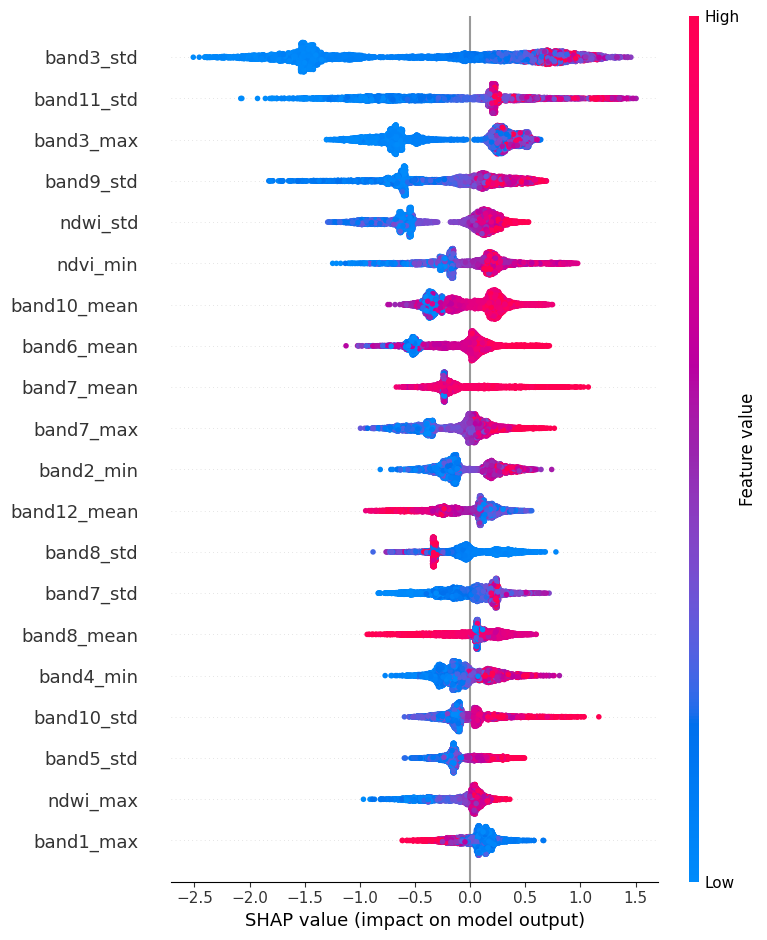

In [170]:
import shap

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

## LGB

In [171]:
# 1️⃣ Train LightGBM
lgb_model = LGBMClassifier(n_estimators=500, max_depth=-1, learning_rate=0.05)
lgb_model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, n_estimators=500)

In [172]:
cross_validate_model(lgb_model, X_train, y_train)

Fold 1/5
Fold 1 F1: 0.8468 | Accuracy: 0.9487
Fold 2/5
Fold 2 F1: 0.8691 | Accuracy: 0.9562
Fold 3/5
Fold 3 F1: 0.8385 | Accuracy: 0.9468
Fold 4/5
Fold 4 F1: 0.8531 | Accuracy: 0.9515
Fold 5/5
Fold 5 F1: 0.8174 | Accuracy: 0.9375
Mean F1 Score: 0.8450
Mean Accuracy: 0.9481


In [173]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "verbose": -1
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []


    model = LGBMClassifier(**params, random_state=42)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='binary_logloss',
        callbacks=[]
        )

    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred))

    return np.mean(f1_scores)

    return np.mean(f1_scores)

optuna.logging.set_verbosity(optuna.logging.CRITICAL)

lgbm_study = optuna.create_study(direction="maximize")
lgbm_study.optimize(objective, n_trials=30)

print("Best F1:", lgbm_study.best_value)
print("Best Params:", lgbm_study.best_params)

Best F1: 0.8618968386023295
Best Params: {'n_estimators': 341, 'learning_rate': 0.24536672518072364, 'max_depth': 14, 'num_leaves': 22, 'subsample': 0.7832176554062932, 'colsample_bytree': 0.6396997607990523, 'min_child_samples': 8}


In [175]:
best_lgbm = LGBMClassifier(**lgbm_study.best_params)
cross_validate_model(best_lgbm, X_train, y_train)

Fold 1/5
Fold 1 F1: 0.8362 | Accuracy: 0.9459
Fold 2/5
Fold 2 F1: 0.8667 | Accuracy: 0.9552
Fold 3/5
Fold 3 F1: 0.8492 | Accuracy: 0.9496
Fold 4/5
Fold 4 F1: 0.8652 | Accuracy: 0.9552
Fold 5/5
Fold 5 F1: 0.8150 | Accuracy: 0.9356
Mean F1 Score: 0.8464
Mean Accuracy: 0.9483


## Block 9: Make Predictions on the Test Set and Prepare Submission

In [153]:
X_preds = testing_df.drop('ID', axis=1)

## Ensemble Models

In [ ]:
def blend_models_f1(model1, model2, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(y))  # out-of-fold predictions
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n🔹 Fold {fold}/{n_splits}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Clone models for each fold to avoid contamination
        m1 = model1.__class__(**model1.get_params())
        m2 = model2.__class__(**model2.get_params())
        
        # Train both models
        m1.fit(X_train, y_train)
        m2.fit(X_train, y_train)
        
        # Get predictions
        p1 = m1.predict_proba(X_val)[:, 1]
        p2 = m2.predict_proba(X_val)[:, 1]
        
        # Average predictions
        avg_pred = (p1 + p2) / 2
        
        # Threshold at 0.5 for binary classification
        oof_preds[val_idx] = (avg_pred > 0.4).astype(int)
        
        fold_f1 = f1_score(y_val, oof_preds[val_idx])
        print(f"Fold {fold} F1 Score: {fold_f1:.4f}")
    
    overall_f1 = f1_score(y, oof_preds)
    print(f"\n✅ Overall F1 Score: {overall_f1:.4f}")


blend_models_f1(best_xgb, best_lgbm, X_df, y_df)

## Single Model

In [199]:
def stratifiedKFold(model):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    test_preds = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_df, y_df)):
        print(f"Fold {fold+1}")
    
        # Use the same DataFrames as in split
        X_tr, X_val = X_df.iloc[train_idx], X_df.iloc[val_idx]
        y_tr, y_val = y_df.iloc[train_idx], y_df.iloc[val_idx]
    
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
        )
    
        # Validation predictions and F1
        y_pred_val = model.predict(X_val)
        f1 = f1_score(y_val, y_pred_val)
        f1_scores.append(f1)
        print(f"Fold {fold+1} F1: {f1:.4f}")
    
        # Test predictions (probabilities)
        y_pred_test = model.predict_proba(X_preds[X_df.columns])[:, 1]
        test_preds.append(y_pred_test)
    
    # ✅ Average test predictions from 5 folds
    final_test_preds = np.mean(test_preds, axis=0)
    
    # ✅ Convert to class labels with custom threshold
    final_labels = (final_test_preds >= 0.3).astype(int)
    
    print("CV Mean F1:", np.mean(f1_scores))
    return final_labels

In [200]:
#y_pred = stratifiedKFold(best_xgb)
y_pred = stratifiedKFold(best_lgbm)

Fold 1
Fold 1 F1: 0.8583
Fold 2
Fold 2 F1: 0.8553
Fold 3
Fold 3 F1: 0.8589
Fold 4
Fold 4 F1: 0.8675
Fold 5
Fold 5 F1: 0.8423
CV Mean F1: 0.8564806066214012


In [198]:
def blend_models_kfold(model1, model2, X_train, y_train, X_test, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    test_preds_folds = []
    oof_preds = np.zeros(len(y_train))

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        print(f"\n🔹 Fold {fold}/{n_splits}")

        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        # Clone models per fold
        m1 = model1.__class__(**model1.get_params())
        m2 = model2.__class__(**model2.get_params())

        # Train models
        m1.fit(X_tr, y_tr)
        m2.fit(X_tr, y_tr)

        # Predict probabilities
        p1_val = m1.predict_proba(X_val)[:, 1]
        p2_val = m2.predict_proba(X_val)[:, 1]
        val_avg = (p1_val + p2_val) / 2
        oof_preds[val_idx] = val_avg

        # Predict test set probabilities
        p1_test = m1.predict_proba(X_test)[:, 1]
        p2_test = m2.predict_proba(X_test)[:, 1]
        test_avg = (p1_test + p2_test) / 2
        test_preds_folds.append(test_avg)

    # Average predictions across folds
    test_preds_final = np.mean(test_preds_folds, axis=0)

    final_preds_binary = (test_preds_final > 0.3).astype(int)

    return final_preds_binary

y_pred = blend_models_kfold(best_lgbm, best_xgb, X_df, y_df, X_preds[X_df.columns])


🔹 Fold 1/5

🔹 Fold 2/5

🔹 Fold 3/5

🔹 Fold 4/5

🔹 Fold 5/5


In [201]:
test_ids = test_df['ID'].values
# Predict probabilities and classify as 0 or 1

# Count the number of predictions for each class
unique, counts = np.unique(y_pred, return_counts=True)
prediction_counts = dict(zip(unique, counts))
print("Prediction counts:", prediction_counts)

# Prepare submission file
submission_df = pd.DataFrame({
    'ID': test_ids,
    'label': y_pred.flatten()  # Flatten to match submission format
})
submission_df.to_csv('/kaggle/working/Submission_File.csv', index=False)
print("Sample submission file created as 'Submission_File.csv'.")

Prediction counts: {0: 4713, 1: 685}
Sample submission file created as 'Submission_File.csv'.


In [ ]:
from xgboost import plot_importance
plot_importance(best_xgb, importance_type='gain', max_num_features=20)
plt.show()

## Transfer Learning

### Explanation
1. **Count Predictions**:
   - After making predictions on `X_test`, we use `np.unique` with `return_counts=True` to count the occurrences of `0`s and `1`s in `y_test_pred`.
   - We print the counts, which shows the distribution of predicted labels.

2. **Interpretation**:
   - The counts provide insight into whether the model is predicting a balanced number of `0`s and `1`s or if it's skewed towards one class.
   - Please consider that the test set is imbalanced towards the non-landslide class.
   - This check is particularly useful for binary classification problems where class imbalance could impact the model’s evaluation.

3. **Prepare Submission File**:
   - The `Submission_File.csv` file is created in the same way, ready for submission.